# Projet 6 : Analysez les ventes d'une librairie avec R ou Python

## **1. Introduction**

### **1.1 Importation des librairies**

In [93]:
#On importe les bibliothèques

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import date
from scipy import stats
import warnings
#pip install researchpy
import researchpy as rp
from scipy.stats import shapiro
from scipy.stats import f
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import bartlett
from statsmodels.formula.api import ols
import statsmodels.api as sm
warnings.filterwarnings('ignore')

### **1.2 Importation du DF nettoyé**

In [94]:
# Importation du df nettoyé dans le 1er Notebook et des 3 fichiers.

customers=pd.read_csv("customers.csv")
products=pd.read_csv("products.csv")
transactions=pd.read_csv("transactions.csv")
df = pd.read_csv('df.csv')

In [95]:
# Verification du fichier

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679111 entries, 0 to 679110
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_prod     679111 non-null  object 
 1   date        679111 non-null  object 
 2   session_id  679111 non-null  object 
 3   client_id   679111 non-null  object 
 4   sex         679111 non-null  object 
 5   birth       679111 non-null  int64  
 6   age         679111 non-null  int64  
 7   price       679111 non-null  float64
 8   categ       679111 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 46.6+ MB


## 2. Les demandes d'Antoine

### 2.1 Le chiffre d'affaires général

In [96]:
#On Groupby selon le numéro de transaction
df_commandes = df.groupby(['session_id', 'client_id', "age"]).agg({'date':'max',                                                                       "session_id":"count", 'price':'sum'})
df_commandes.rename(columns={'session_id':"number_items"}, inplace=True)
df_commandes = df_commandes.reset_index()
df_commandes.head()

,session_id,client_id,age,date,number_items,price
0,s_1,c_329,56,2021-03-01 00:01:07.843138,1,11.99
1,s_10,c_2218,53,2021-03-01 00:10:33.163037,1,26.99
2,s_100,c_3854,45,2021-03-01 04:43:58.025677,2,33.72
3,s_1000,c_1014,34,2021-03-03 03:25:12.320225,4,39.22
4,s_10000,c_476,34,2021-03-22 18:15:03.831240,3,41.49


In [97]:
#Affichage de la date minimal
df.date.min()

'2021-03-01 00:01:07.843138'

In [98]:
#Affichage de la date maximal
df.date.max()

'2023-02-28 23:58:30.792755'

In [99]:
#Calcul du chiffre d'affaire de Janvier 2021 à Fevrier 2023
CA = round(df['price'].sum(), 2)
print("Le chiffre d'affaire de Mars 2021 à Fevrier 2023 est de",CA,"€")

Le chiffre d'affaire de Mars 2021 à Fevrier 2023 est de 11853728.68 €


### 2.2 L'évolution du chiffre d'affaires

#### 2.2.1 Séparation de la date

In [100]:
#On sépare la date de l'heure
df[["date", "hour"]] = df.date.str.split(" ", expand=True)

In [101]:
#Convertion de la date en datetime
df['date']=pd.to_datetime(df['date'])

In [102]:
#Création d'une colonne année
df["année"]=df.date.dt.year

In [103]:
#Création d'une colonne mois
df["mois"]=df.date.dt.month

In [104]:
#Création d'une colonne jour
df["jour"]=df.date.dt.day

In [105]:
df

,id_prod,date,session_id,client_id,sex,birth,age,price,categ,hour,année,mois,jour
0,0_1518,2022-05-20,s_211425,c_103,f,1986,37,4.18,0.0,13:21:29.043970,2022,5,20
1,0_1627,2022-06-18,s_225494,c_103,f,1986,37,3.99,0.0,05:55:31.816994,2022,6,18
2,0_1104,2023-02-08,s_338755,c_103,f,1986,37,13.21,0.0,17:31:06.898425,2023,2,8
3,0_1390,2021-04-20,s_23078,c_103,f,1986,37,19.37,0.0,06:18:39.939761,2021,4,20
4,0_1547,2022-03-15,s_179629,c_103,f,1986,37,8.99,0.0,19:54:53.904123,2022,3,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
679106,0_1509,2021-05-15,s_34762,c_8114,m,1962,61,4.99,0.0,08:17:35.835342,2021,5,15
679107,1_152,2021-11-08,s_116675,c_240,m,1998,25,11.06,1.0,17:12:27.637349,2021,11,8
679108,2_207,2021-06-01,s_42418,c_305,f,1996,27,50.99,2.0,04:31:16.088314,2021,6,1
679109,1_521,2022-10-18,s_284060,c_305,f,1996,27,22.99,1.0,00:38:49.629165,2022,10,18


#### 2.2.2 Visuel du CA par année

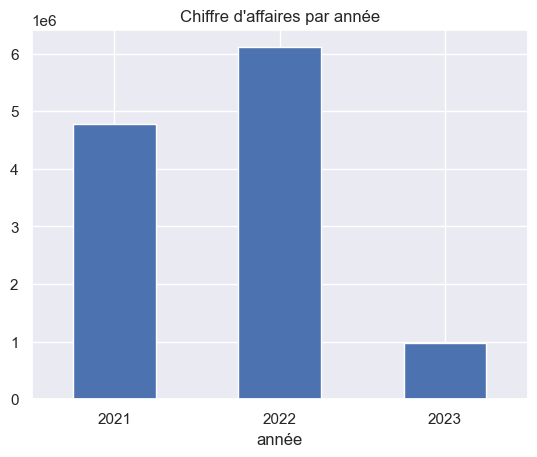

In [106]:
df.groupby('année')['price'].sum().plot(kind = 'bar')
plt.title('Chiffre d\'affaires par année')
plt.xticks(rotation=0, ha='center')
plt.show()

#### 2.2.3 Le CA par mois

In [107]:
ca_mois = df[["price","date"]].set_index("date").groupby(pd.Grouper(freq="M")).sum()

In [108]:
ca_mois

,price
date,
2021-03-31,482440.61
2021-04-30,476109.30
2021-05-31,492943.47
2021-06-30,484088.56
2021-07-31,482835.40
2021-08-31,482284.79
2021-09-30,507240.68
2021-10-31,320798.74
2021-11-30,516167.73


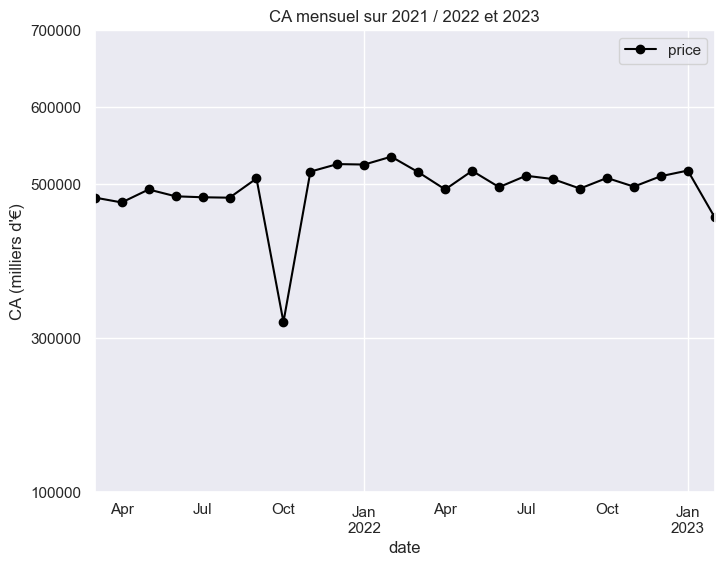

In [109]:
#On regarde l'evolution du chiffre d'affaires mensuel sur les 2 années
ca_mois.plot(figsize=(8,6),marker="o",color="black",yticks=(100000,300000,500000,600000,700000))
plt.title("CA mensuel sur 2021 / 2022 et 2023")
plt.ylabel("CA (milliers d'€)")
plt.show()

**On remarque une forte baisse du chiffre d'affaires uniquement pour le mois d'octobre 2021, nous allons creuser cette différence avec les autres mois.**

#### 2.2.3 Analyse du CA journalier

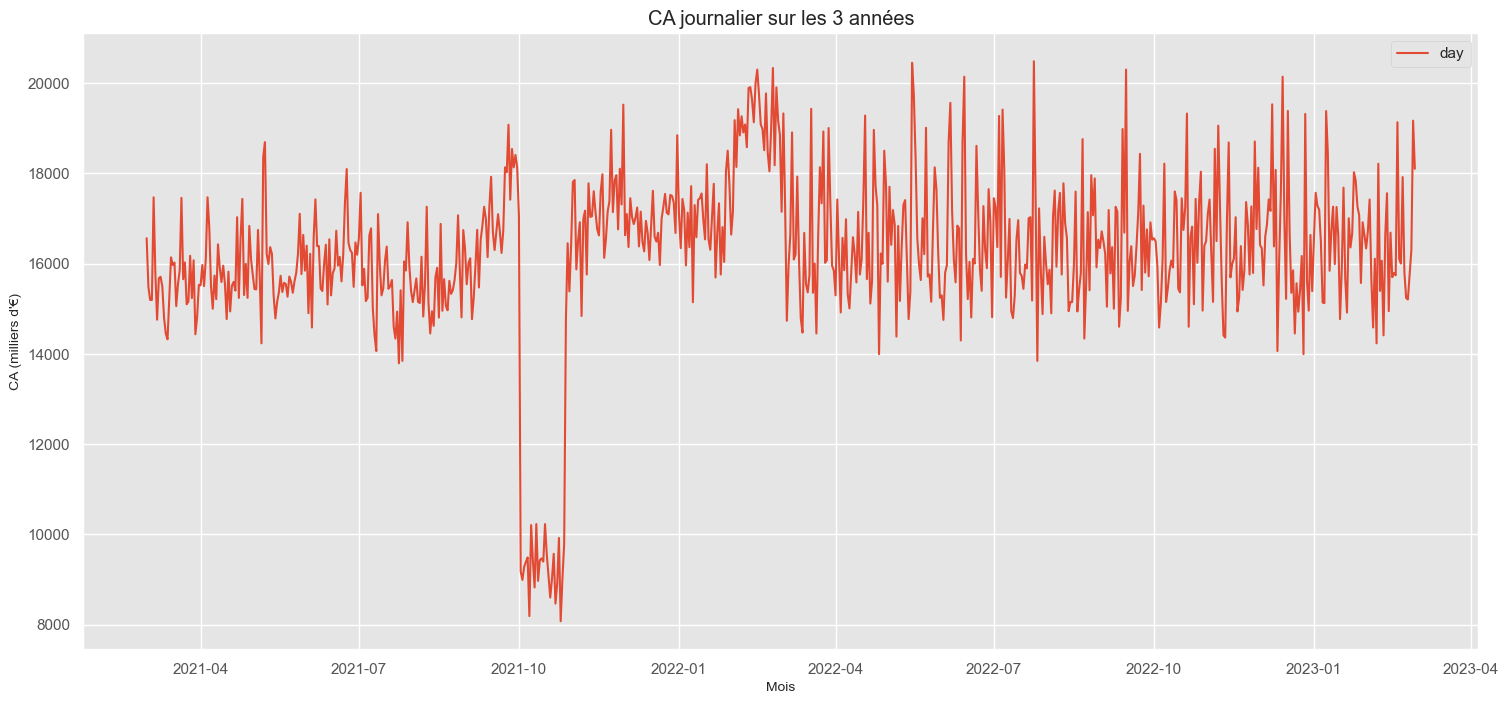

In [110]:
#On regarde l'evolution du chiffre d'affaires journalier sur les 3 années

df["jour"]=df.date.dt.day
ca_days=df[["price","date"]].set_index("date").groupby(pd.Grouper(freq="D")).sum()

plt.style.use('ggplot')
plt.figure(figsize=(18,8))
plt.plot(ca_days,label= 'day')
plt.legend(loc='best')
plt.title('CA journalier sur les 3 années')
plt.xlabel("Mois")
plt.ylabel("CA (milliers d'€)")
plt.show()

#plt.savefig("CAjournalier.jpg")

**C'est assez compliqué à lire, nous allons effectuer une décomposition en moyenne mobile pour plus de clarté**

In [111]:
ca_days=df[["price","date"]].set_index("date").groupby(pd.Grouper(freq="D")).sum()

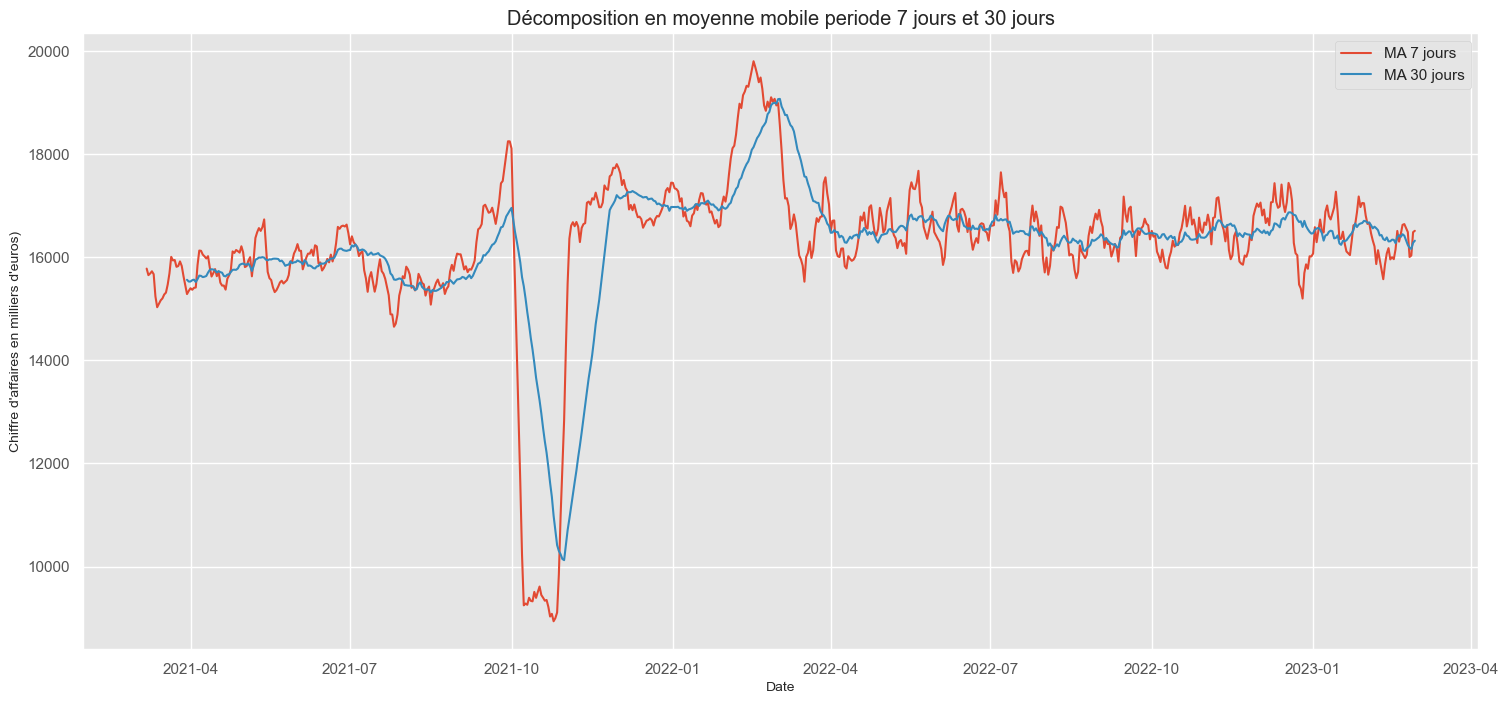

In [112]:
#On affiche une decomposition en moyenne mobile pour une periode de 7 et 30 jours

plt.style.use('ggplot')
plt.figure(figsize=(18,8))
plt.plot(ca_days.rolling(7).mean(),label= 'MA 7 jours')
plt.plot(ca_days.rolling(30).mean(),label= 'MA 30 jours')
plt.legend(loc='best')
plt.title('Décomposition en moyenne mobile periode 7 jours et 30 jours')
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaires en milliers d'euros)")
plt.show()

#### 2.2.4 Analyse du mois d'Octobre

In [113]:
#On Stock dans la variable toutes les commandes passées en octobre 2021
df_octobre_2021 = df.loc[(df['année']==2021) & (df['mois']==10),:]

In [114]:
#On effectue la somme du chiffre d'affaire par catégorie et par jour
df_octobre_2021 = pd.pivot_table(df_octobre_2021, index = ['jour'], columns = 'categ', values = 'price',aggfunc={'price':'sum'});

In [115]:
#Apperçu du chiffre d'affaires de chaque catégorie au mois d'Octobre
df_octobre_2021.sum()

categ
0.0    199250.83
1.0     33762.32
2.0     87785.59
dtype: float64

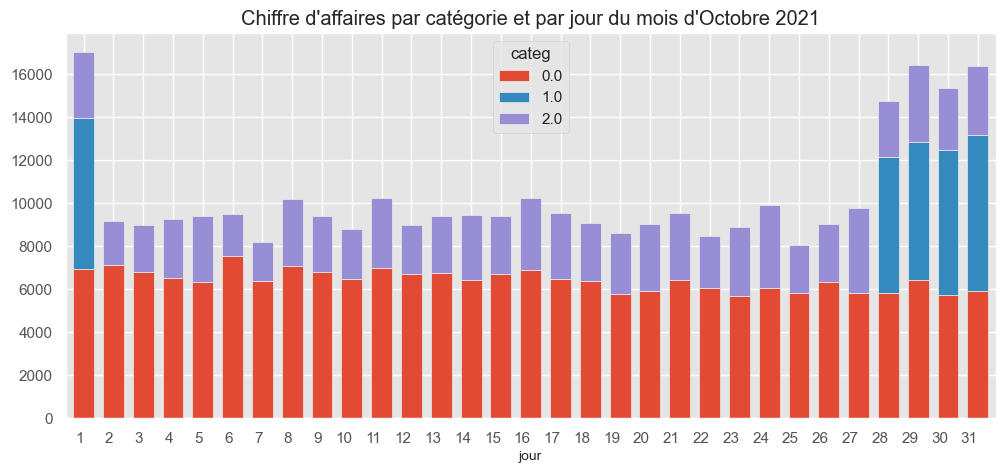

In [116]:
#On affiche le tout sous forme de bar
df_octobre_2021.plot(kind='bar',stacked = True,figsize=(12,5),width = 0.7)
plt.title("Chiffre d'affaires par catégorie et par jour du mois d'Octobre 2021")
plt.xticks(rotation =0,ha='right')
plt.show()

**On remarque l'absence d'achat des produits de la catégorie 1 entre le 2 et le 28 octobre 2021. Deux hypothèses possibles : Soit un arrêt des ventes de catégorie 1 à ce moment là, ou probablement un bug informatique qui a empêché d'obtenir les données de ventes qui ont eu lieu sur cette periode. Afin d'avoir une analyse plus précise notamment pour l'analyse des produits nous allons donc isoler le CA du mois d'octobre et le supprimer du DF**

In [117]:
# Suppresion des transactions de Octobre 2021
df = df[~((df['mois'] == 10) & (df['année'] == 2021))]

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 657512 entries, 0 to 679110
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     657512 non-null  object        
 1   date        657512 non-null  datetime64[ns]
 2   session_id  657512 non-null  object        
 3   client_id   657512 non-null  object        
 4   sex         657512 non-null  object        
 5   birth       657512 non-null  int64         
 6   age         657512 non-null  int64         
 7   price       657512 non-null  float64       
 8   categ       657512 non-null  float64       
 9   hour        657512 non-null  object        
 10  année       657512 non-null  int64         
 11  mois        657512 non-null  int64         
 12  jour        657512 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(5)
memory usage: 70.2+ MB


### 2.3 Zoom sur les références (Les TOP / les FLOP / La répartition par catégorie)

#### 2.3.1 Le top des articles en CA

In [119]:
df_prod = df.groupby('id_prod').agg({"id_prod":"count", 'price':'sum'})
df_prod.rename(columns={"id_prod":"number_purchases", "price":"monetary_value"}, inplace=True)

In [120]:
#On va trier le dataframe selon les meilleurs produits en terme de CA 
meilleurs_prod_montant = df_prod.sort_values(by=['monetary_value'], ascending = False)

In [121]:
#Affichage des produits qui ont rapporté le plus d'argent
meilleurs_prod_montant.head()

,number_purchases,monetary_value
id_prod,,
2_159,632,92265.68
2_135,977,67403.23
2_112,930,62840.10
2_102,997,58962.58
2_209,791,55362.09


#### 2.3.2 Le top des articles en nombre de ventes

In [122]:
#On va trier le dataframe selon les meilleurs produits en terme de ventes
meilleurs_prod_nb_achats = df_prod.sort_values(by=['number_purchases'], ascending = False)

In [123]:
#Produits les plus vendus
meilleurs_prod_nb_achats.head()

,number_purchases,monetary_value
id_prod,,
1_369,2237,53665.63
1_417,2173,45611.27
1_414,2166,51615.78
1_498,2117,49474.29
1_425,2084,35407.16


#### 2.3.3 Le flop des articles en CA

In [124]:
#Tri dans l'ordre décroissant pour avoir les plus grandes valeurs en premier
pire_prod_montant = df_prod.sort_values(by=['monetary_value'], ascending = True)

In [125]:
#Affichage des pires produits en terme de CA
pire_prod_montant.head()

,number_purchases,monetary_value
id_prod,,
0_1539,1,0.99
0_898,1,1.27
0_1284,1,1.38
0_643,2,1.98
0_1653,2,1.98


#### 2.3.4 Le flop des articles en nombre de ventes

In [126]:
pires_prod_nb_achats = df_prod.sort_values(by=['number_purchases'], ascending = True)

In [127]:
#Affichage des pires produits en terme de ventes
pires_prod_nb_achats.head()

,number_purchases,monetary_value
id_prod,,
0_1151,1,2.99
0_898,1,1.27
0_886,1,21.82
0_833,1,2.99
0_807,1,1.99


#### 2.3.5 La répartition par catégorie produits

In [128]:
# On Crée un sous-df avec un groupby sur la colonne "categ"

df_categ = df.groupby(["categ"]).agg({"client_id" : 'count', "price" : "sum"})

df_categ.rename(columns={"client_id" : "total_purchases", "price" : "monetary_value"}, inplace=True)

df_categ=pd.DataFrame(df_categ)
df_categ.reset_index(inplace=True)

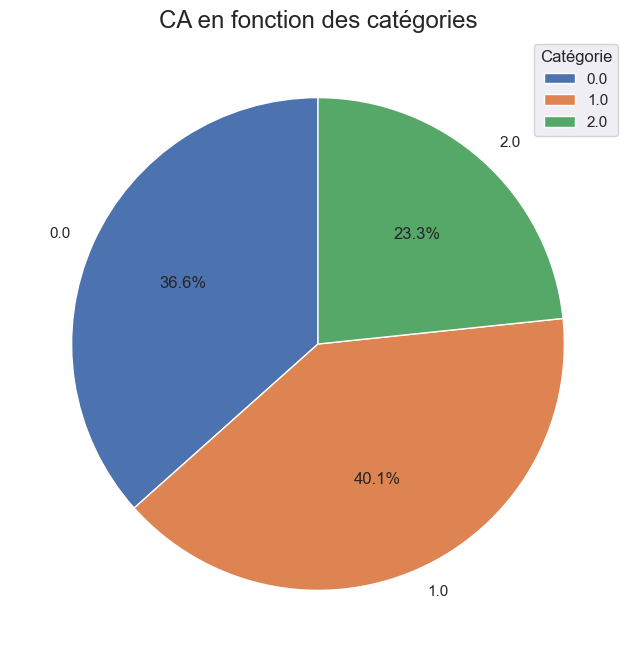

In [129]:
#On affiche le CA en fonction des catégories
sns.set()
plt.figure(figsize=(8,8))
plt.pie(df_categ.monetary_value, labels=df_categ.categ, shadow=False, startangle=90, autopct='%1.1f%%')
plt.title("CA en fonction des catégories", fontsize = 'x-large')
plt.legend(title="Catégorie")
plt.show()

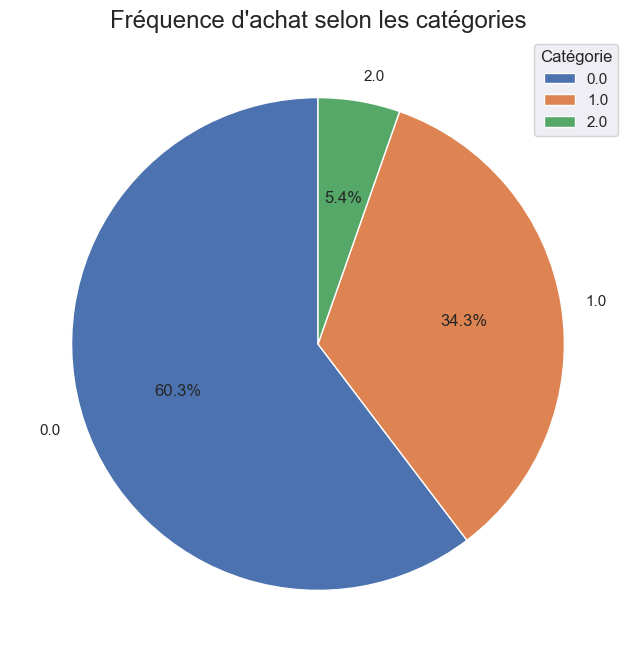

In [130]:
#On affiche la fréquence d'achat selon les catégories
plt.figure(figsize=(8,8))
plt.pie(df_categ.total_purchases, labels=df_categ.categ, shadow=False, startangle=90, autopct='%1.1f%%')
plt.title("Fréquence d'achat selon les catégories", fontsize = 'x-large')
plt.legend(title="Catégorie")
plt.show()

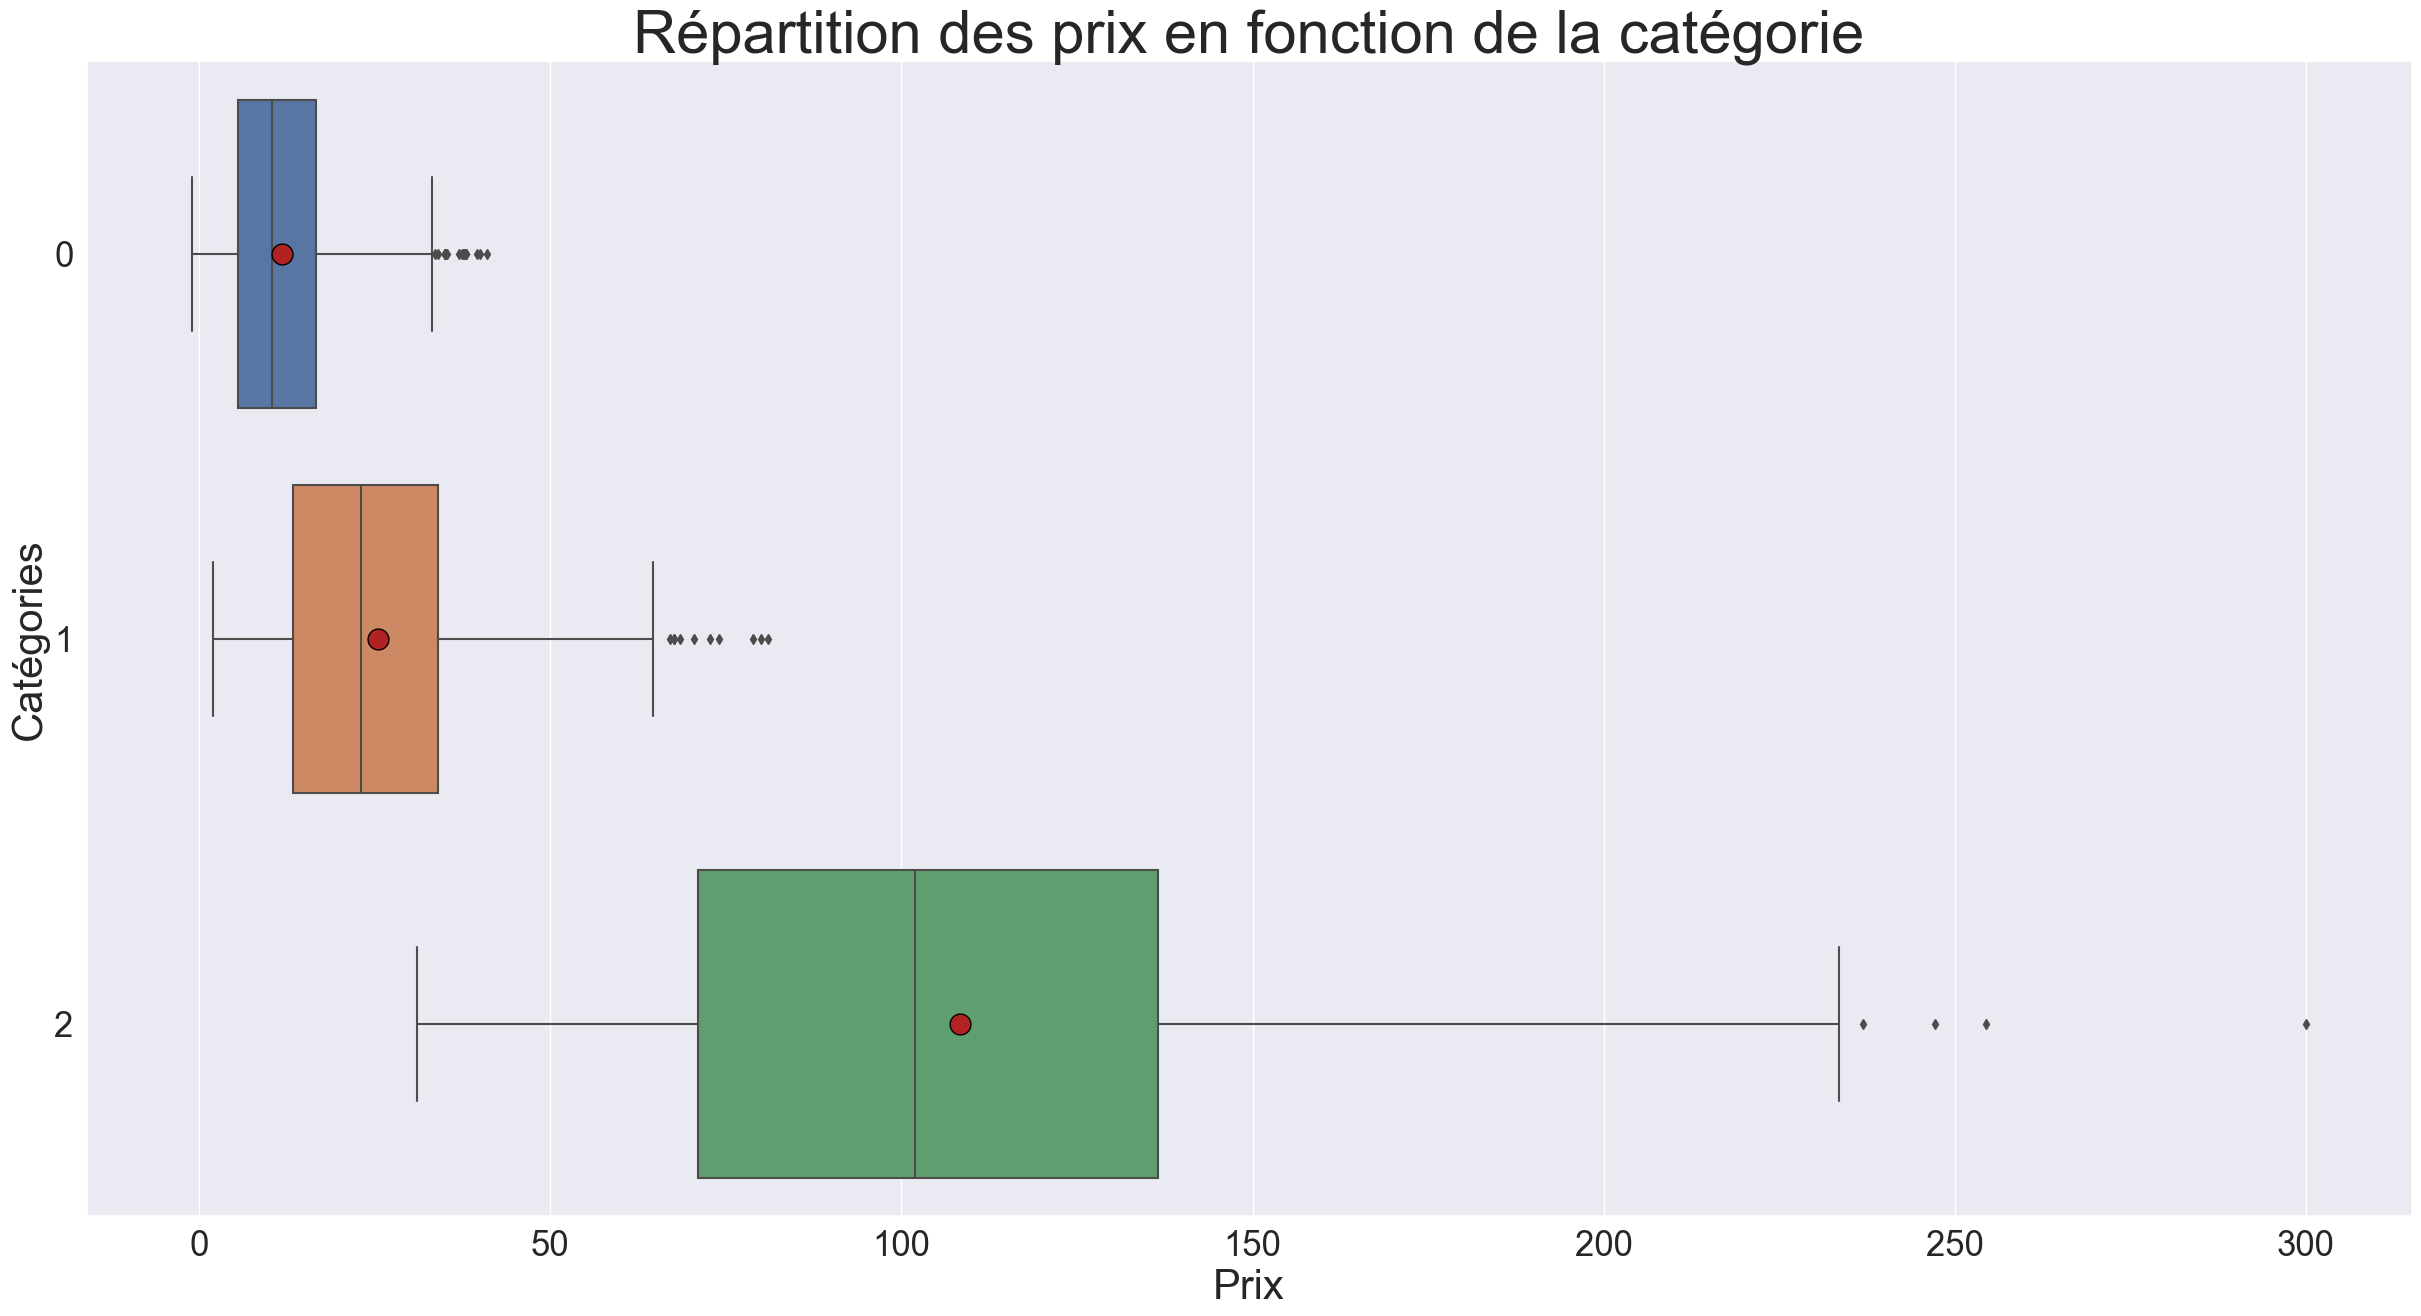

In [131]:
products.categ=products.categ.astype("category")

meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick', "markersize":'15'}

plt.figure(figsize=(30,15))
sns.boxplot(y="categ", x="price",data=products, showmeans=True, meanprops=meanprops)
plt.title('Répartition des prix en fonction de la catégorie', fontsize='43')
plt.xlabel('Prix', fontsize='30')
plt.ylabel("Catégories", fontsize='30')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

#### 2.3.6 L'equilibre des ventes selon les produits

In [132]:
# Création d'un df restreint
ca_produits = df.groupby(["id_prod", "price"]).agg({"price" : "sum"})

ca_produits = ca_produits.rename(columns={"price":"sum_price"})
ca_produits = pd.DataFrame(ca_produits)

ca_produits.head()

,,sum_price
id_prod,price,
0_0,3.75,4477.50
0_1,10.99,5154.31
0_10,17.95,323.10
0_100,20.60,61.80
0_1000,6.84,2790.72


In [133]:
#On prepare la courbe de Lorenz : l'équilibre des ventes selon les produits

ventes_prod = ca_produits['sum_price'].values
n = len(ventes_prod)
lorenz = np.cumsum(np.sort(ventes_prod)) / ventes_prod.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

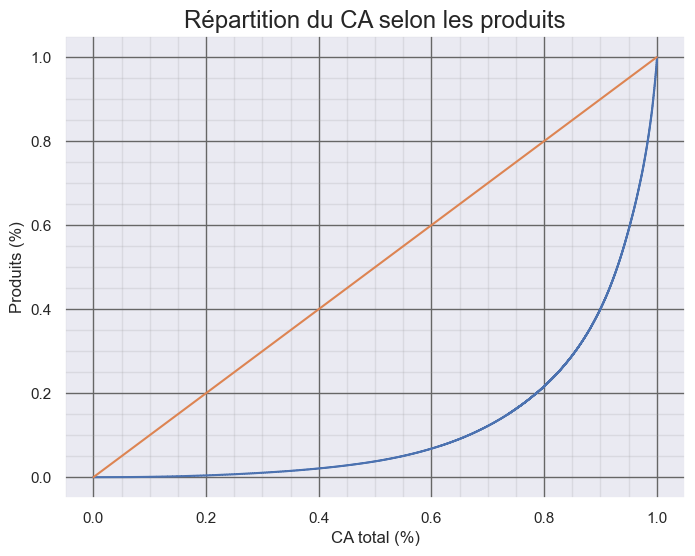

In [134]:
fig, ax = plt.subplots(1, figsize=(8, 6))
xaxis = np.linspace(0-1/n,1+1/n,n+1)
ax.plot(xaxis,lorenz,drawstyle='steps-post')
ax.plot([0,1])
plt.title("Répartition du CA selon les produits", fontsize='x-large')
plt.xlabel("CA total (%)")
plt.ylabel("Produits (%)")
plt.grid(True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(True, which='minor', color='#999999', linestyle='-', alpha=0.2)

#plt.savefig("produits.jpeg", format="jpeg")

In [135]:
# Calcul de l'indice de Gini

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n
S = 0.5 - AUC # surface entre la première bissectrice et la courbe de Lorenz
gini = 2*S
gini

0.7443878055186466

**L'indice de Gini est important, la répartition du CA selon les produits est très inégalitaire : peu de produits rapportent beaucoup, et beaucoup de produits rapportent peu.**

**La loi de Pareto est respectée : 20% des produits font 80% du CA et 80% des produits font 20% du CA.**

### 2.4 Analyse sur les clients

In [136]:
#On répartit en fonction de l'âge et du sexe

clients_age = df[["client_id", "age", "sex"]].groupby("client_id").max()
clients_age = pd.DataFrame(data=clients_age, columns=['age', 'sex'])
clients_age.head()

,age,sex
client_id,,
c_1,68,m
c_10,67,m
c_100,31,m
c_1000,57,f
c_1001,41,m


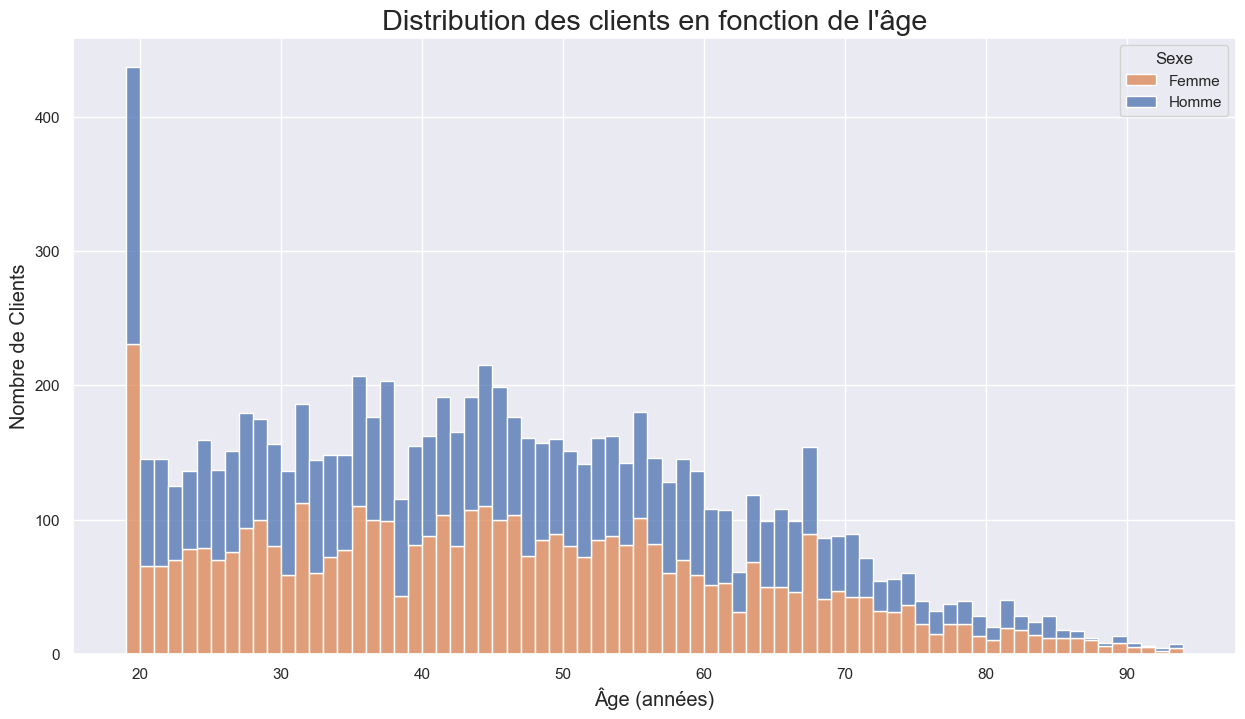

In [137]:
#On affiche un graphique en fonction de l'age et du sexe des clients corriger graphe
sns.set_theme(style="darkgrid")

plt.figure(figsize=(15,8))
plt.title("Distribution des clients en fonction de l'âge", fontsize='xx-large')
plt.xlabel('Âge (années)', fontsize='large')
plt.ylabel('Nombre de Clients', fontsize='large')
sns.histplot(data=clients_age, x="age", hue="sex", multiple="stack", bins=75)
plt.legend(["Femme", "Homme"], title="Sexe")
plt.show()

**Il y a une répartition identique des clients hommes et des clients femmes en fonction de leur âge.**

**Les clients sont donc des hommes et des femmes dont la moitié a plus de 45 ans et l'autre moitié moins de 45 ans, avec la moitié des clients entre 35 et 55 ans environ.**

**La tranche 19 ans est certainement un outlier, elle peut comprendre tous ceux qui sont trop jeunes pour commander et se sont créés un compte 18 ans l'année dernière, et des gens qui ne souhaitent pas donner leur âge. Comme nous sommes en 2023 et que ma colonne age est le calcul de 2023 moins l'année de naissance tous ces comptes crées l'année dernière avec l'age de 18 ans ont donc 19 ans cette année.**

In [138]:
#On masque la tranche d'age 19 ans pour effectuer un test de student
df_student=df.mask(df.age==19)
import researchpy as rp
rp.ttest(group1= df_student['age'][df_student['sex']=='m'], group1_name = 'Male',
        group2= df_student['age'][df_student['sex']=='f'], group2_name = 'Female')

(   Variable         N       Mean         SD        SE  95% Conf.   Interval
 0      Male  322666.0  45.226525  12.860921  0.022641  45.182150  45.270901
 1    Female  320077.0  46.430312  13.449428  0.023773  46.383718  46.476906
 2  combined  642743.0  45.825994  13.171029  0.016429  45.793795  45.858194,
               Independent t-test      results
 0  Difference (Male - Female) =       -1.2038
 1          Degrees of freedom =   642741.0000
 2                           t =      -36.6749
 3       Two side test p value =        0.0000
 4      Difference < 0 p value =        0.0000
 5      Difference > 0 p value =        1.0000
 6                   Cohen's d =       -0.0915
 7                   Hedge's g =       -0.0915
 8              Glass's delta1 =       -0.0936
 9            Point-Biserial r =       -0.0457)

In [143]:
# On Contrôle la normalité des échantillons 'age' et 'sex'

X1 = df_student['age'][df_student['sex']=='m']

X2 = df_student['age'][df_student['sex']=='f']

from scipy.stats import shapiro

x1, pval1 = shapiro(X1)

x2, pval2 = shapiro(X2)

print(pval1)

print(pval2)

0.0
0.0


In [144]:
#On Contrôle l'égalité des variances :

# Fisher-Snedecor F-test

from scipy.stats import f

f(X1,X2)


# Anova unidirectionnelle

import scipy.stats as stats

stats.f_oneway(X1,X2)

F_onewayResult(statistic=1345.0463869780904, pvalue=3.7134024942125816e-294)

In [145]:
#On Compare les deux échantillons pour voir s'ils sont significativement différents

y = stats.ttest_ind(X1,X2) ; print(y)

Ttest_indResult(statistic=-36.67487405538138, pvalue=3.7134024941075526e-294)


In [146]:
#On Affiche la p-value seule

print(y[1])

3.7134024941075526e-294


In [147]:
# Je regroupe mes données par client_id et j'affiche le montant de leurs achats.
df_client = df.groupby('client_id',)[['price']].sum();
df_client.head()

,price
client_id,
c_1,550.19
c_10,1353.60
c_100,254.85
c_1000,2209.92
c_1001,1720.08


In [148]:
# Je tri les données de la colonne price par ordre décroissant pour avoir les clients ayant dépensé le plus
df_client.sort_values('price', ascending = False)

,price
client_id,
c_1609,312755.08
c_4958,282654.61
c_6714,149783.75
c_3454,111766.71
c_2899,5214.05
...,...
c_2793,12.99
c_4648,11.20
c_240,11.06


**On a 4 gros clients qui se détache en terme de CA total, au vu du différentiel avec le 5eme ce sont probablement des entreprises**

In [149]:
# Je crée un nouveau dataframe qui contient toutes les données des 4 clients
df_4_clients = df.loc[(df['client_id']=='c_1609')|(df['client_id']=='c_4958')|(df['client_id']=='c_6714')
                      |(df['client_id']=='c_3454'),:]

In [150]:
df_4_clients

,id_prod,date,session_id,client_id,sex,birth,age,price,categ,hour,année,mois,jour
442,0_1277,2022-06-18,s_225667,c_6714,f,1968,55,7.99,0.0,15:44:33.155329,2022,6,18
443,1_661,2022-09-13,s_267366,c_6714,f,1968,55,22.99,1.0,10:18:02.746197,2022,9,13
445,1_446,2022-02-04,s_159894,c_6714,f,1968,55,23.92,1.0,14:53:30.833353,2022,2,4
446,1_445,2022-08-24,s_257657,c_6714,f,1968,55,23.99,1.0,05:38:17.574112,2022,8,24
447,0_1432,2021-05-13,s_33987,c_6714,f,1968,55,15.36,0.0,13:24:59.854724,2021,5,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65560,0_1810,2023-01-26,s_332688,c_3454,m,1969,54,5.96,0.0,13:50:58.578116,2023,1,26
65561,1_277,2022-07-25,s_243399,c_3454,m,1969,54,25.99,1.0,04:51:13.350122,2022,7,25
65562,1_442,2022-01-25,s_155151,c_3454,m,1969,54,24.98,1.0,20:40:55.096312,2022,1,25
65563,0_1586,2022-03-11,s_177655,c_3454,m,1969,54,12.71,0.0,14:21:30.970320,2022,3,11


In [151]:
moyenne_ca = (df_4_clients['price'].sum()/df['price'].sum())*100
print("Les 4 plus gros clients représentent environ", round((moyenne_ca),2),"%" , "du chiffre d'affaire total")

Les 4 plus gros clients représentent environ 7.43 % du chiffre d'affaire total


## Repartition CA en fonction des clients

In [152]:
#On prepare une courbe de Lorenz : la répartition du CA en fonction des clients

clients_temp = df_client.price.values
n = len(clients_temp)
lorenz = np.cumsum(np.sort(clients_temp)) / clients_temp.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

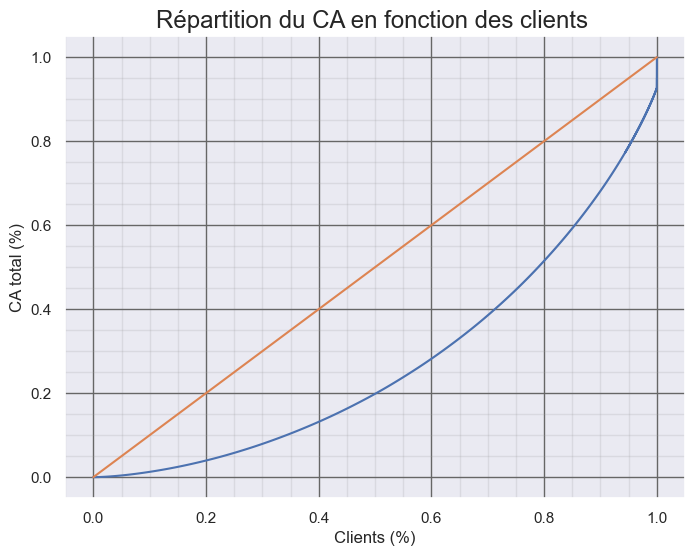

In [153]:
#On affiche une courbe de Lorenz : la répartition du CA en fonction des clients

fig, ax = plt.subplots(1, figsize=(8, 6))
xaxis = np.linspace(0-1/n,1+1/n,n+1)
ax.plot(xaxis,lorenz,drawstyle='steps-post')
ax.plot([0,1])
plt.title("Répartition du CA en fonction des clients ", fontsize='x-large')
plt.xlabel("Clients (%)")
plt.ylabel("CA total (%)")
plt.grid(True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

#plt.savefig("CA_clients_lorenz.jpeg", format="jpeg")

In [154]:
#On calcul l'indice de Gini

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n
S = 0.5 - AUC # surface entre la première bissectrice et la courbe de Lorenz
gini = 2*S
gini

0.4473981709680278

**L'indice de Gini est moyen, légèrement inférieur à 0,50. La répartition du CA en fonction des clients n'est pas préoccupante.**

**J'observe que la loi de Pareto n'est pas respectée : 50% des clients font 20% du CA, et 50% font 80% du CA.**

**J'observe aussi que la fin de la courbe est verticale : cela correspond aux 4 meilleurs clients, qui représentent un gros montant du CA (outliers).**

## 3. Les demandes de Julie

### 3.1 les corrélations entre le genre d’un client et les catégories des livres achetés.

In [155]:
#On masque les quatre outliers rencontrés (plus gros montant), et les valeurs qui ont pour âge "19" qui ne sont pas repésentatif (outliers)
df=df.mask(df.age==19)

df.drop( df[ df['client_id'] == "c_1609" ].index, inplace=True)
df.drop( df[ df['client_id'] == "c_4958" ].index, inplace=True)
df.drop( df[ df['client_id'] == "c_6714" ].index, inplace=True)
df.drop( df[ df['client_id'] == "c_3454" ].index, inplace=True) 

df_commandes=df_commandes.mask(df_commandes.age==19)
df_commandes.drop( df_commandes[ df_commandes['client_id'] == "c_1609" ].index, inplace=True)
df_commandes.drop( df_commandes[ df_commandes['client_id'] == "c_4958" ].index, inplace=True)
df_commandes.drop( df_commandes[ df_commandes['client_id'] == "c_6714" ].index, inplace=True)
df_commandes.drop( df_commandes[ df_commandes['client_id'] == "c_3454" ].index, inplace=True)

#### 3.1.1 Création d'un tableau de contingence

In [156]:
#Corrélation sexe des clients / catégorie de produits achetés

#qualitatif/ qualitatif

# Tableau de contingence réel
df.categ=df.categ.astype("float64")

X="categ"
Y="sex"
cs=df[[X,Y]].pivot_table(index=X, columns=Y, aggfunc=len)
cs.head()

sex,f,m
categ,,
0.0,190082,176499
1.0,107653,97453
2.0,13445,12520


**Nous pouvons voir qu'il y a plus de ventes chez les femmes que chez les hommes dans toutes les catégories**

#### 3.1.2 Calcul du coefficient de Khi2

Test de Khi2

Avec un risque premier alpha de 5%, on émets les deux hypothèses suivantes:

H0: Les deux variables (le genre d’un client et les catégories des livres achetés ) sont indépendantes

H1: les deux variables ne sont pas indépendantes

In [157]:
cont=cs.copy()
tx=df[X].value_counts()
ty=df[Y].value_counts()

cont.loc[:,"Total"]=tx
cont.loc["Total",:]=ty
cont.loc["Total","Total"]=len(df)
cont

sex,f,m,Total
categ,,,
0.0,190082.0,176499.0,366581.0
1.0,107653.0,97453.0,205106.0
2.0,13445.0,12520.0,25965.0
Total,311180.0,286472.0,612421.0


In [158]:
chi2, pvalue, degrees, expected = stats.chi2_contingency(cont)
chi2, degrees, pvalue

(111.77594222172286, 6, 8.655807965080634e-22)

**Notre p-value < 0.05 (alpha = 5%), on rejete H0 et on peut alors conclure que les variables genre et catégorie de produits sont dépendantes.**

#### 3.1.2 La Heatmap

In [159]:
#Corrélation sexe des clients / catégorie de produits achetés

#qualitatif/ qualitatif

# Tableau de contingence réel
df.categ=df.categ.astype("float64")

X="categ"
Y="sex"
cs=df[[X,Y]].pivot_table(index=X, columns=Y, aggfunc=len)
cs.head()

sex,f,m
categ,,
0.0,190082,176499
1.0,107653,97453
2.0,13445,12520


In [160]:
cont=cs.copy()
tx=df[X].value_counts()
ty=df[Y].value_counts()

cont.loc[:,"Total"]=tx
cont.loc["total",:]=ty
cont.loc["total","Total"]=len(df)
cont

sex,f,m,Total
categ,,,
0.0,190082.0,176499.0,366581.0
1.0,107653.0,97453.0,205106.0
2.0,13445.0,12520.0,25965.0
total,311180.0,286472.0,612421.0


In [161]:
#Tableau de contingence théorique

tx = pd.DataFrame(tx)
ty = pd.DataFrame(ty)
tx.columns= ['foo']
ty.columns= ['foo']
n = len(df)
indep = tx.dot(ty.T)/n

indep.sort_index(axis=1, inplace=True)
indep.sort_index(inplace=True)
indep

,f,m
0.0,186265.127388,171475.491912
1.0,104217.335918,95942.376293
2.0,13193.193408,12145.640793


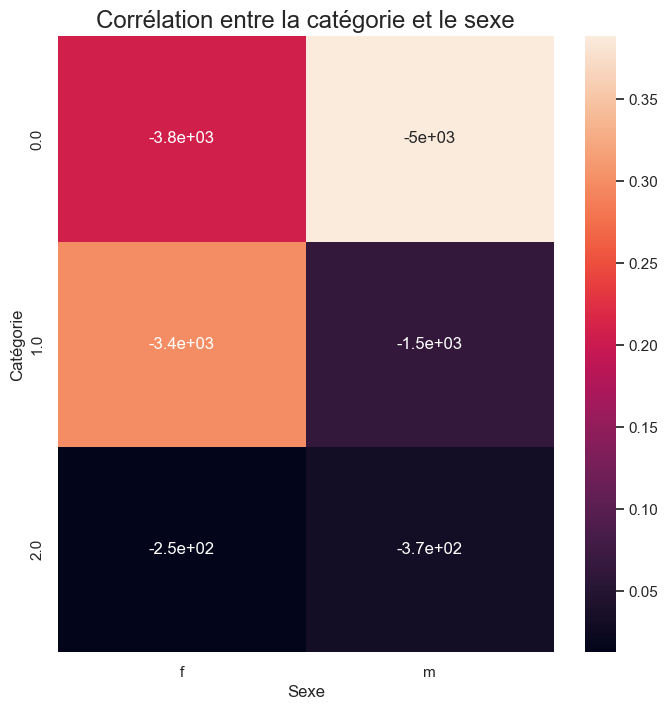

In [162]:
mesure = (cs-indep)**2/indep
xi_n = mesure.sum().sum()

plt.figure(figsize=(8,8))
sns.heatmap(mesure/xi_n, annot=indep - cs)
plt.title("Corrélation entre la catégorie et le sexe", fontsize = 'x-large')
plt.xlabel("Sexe")
plt.ylabel("Catégorie")
plt.show()

Il y a une incidence moyenne du sexe sur la catégorie concernant la catégorie 0 (plus forte pour les hommes que pour les femmes), une incidence faible concernant la catégorie 1(plus forte pour les femmes que pour les hommes), et une incidence très faible concernant la catégorie 2(identique pour les hommes et les femmes).

### 3.2 Les corrélations entre l'âge des clients et montant total des achats

**Nous avons ici deux variables quantitatives (age et montant), je vais donc les analyser comme ce qui suit :**

**Visualisation avec nuage de points avec la régression linéaire**

**Test de corrélation (pearson)**

In [163]:
# Créer la dataframe avec âge et somme de CA
age_ca = df.groupby('age')['price'].agg(['count', 'sum']).sort_values('sum', ascending=False).reset_index()
age_ca.head()

,age,count,sum
0,44.0,23924,323400.70
1,35.0,24168,321409.83
2,45.0,23834,315423.63
3,37.0,22567,299112.68
4,43.0,21146,280776.59


(18.0, 95.0)

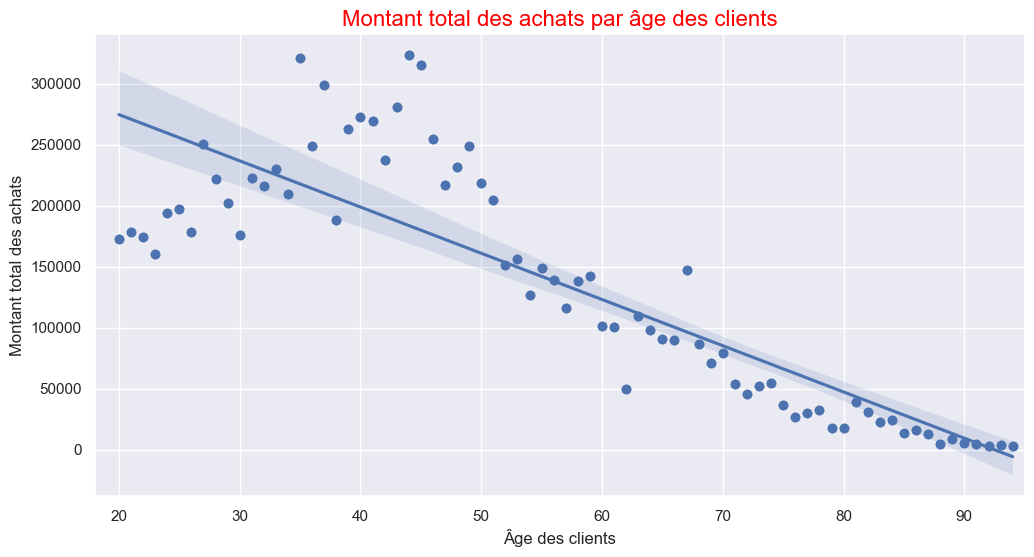

In [164]:
# Visualisation de CA en fonction d'âge des clients
plt.figure(figsize=(12, 6))
sns.regplot(x='age', y='sum', data = age_ca)
plt.scatter(age_ca['age'],age_ca['sum'])
plt.ylabel('Montant total des achats')
plt.xlabel('Âge des clients')
plt.title("Montant total des achats par âge des clients",fontsize= 16, color = 'red')
plt.xlim(18,95)

In [165]:
print('La covariance est de:', np.cov(age_ca['age'], age_ca['sum'],ddof=0)[1,0])
print('Le coefficient de corrélation linéaire est de:', stats.pearsonr(age_ca['age'], age_ca['sum'])[0])

La covariance est de: -1776888.894266667
Le coefficient de corrélation linéaire est de: -0.8560853522156991


**En utilisant le test de Pearson, j’obtient un coefficient de -0.85. Il représente une forte corrélation entre l’âge des clients et le montant total des achats : Plus un client est âgé et moins le montant total des achats sera élevé. (Visible via la régression linéaire)**

### 3.3 Les corrélations entre l'âge et la fréquence d'achats

**Nous avons ici deux variables quantitatives , je vais donc les analyser comme ce qui suit :**

**Visualisation avec nuage de points avec la régression linéaire**

**Test de corrélation (pearson)**

(18.0, 95.0)

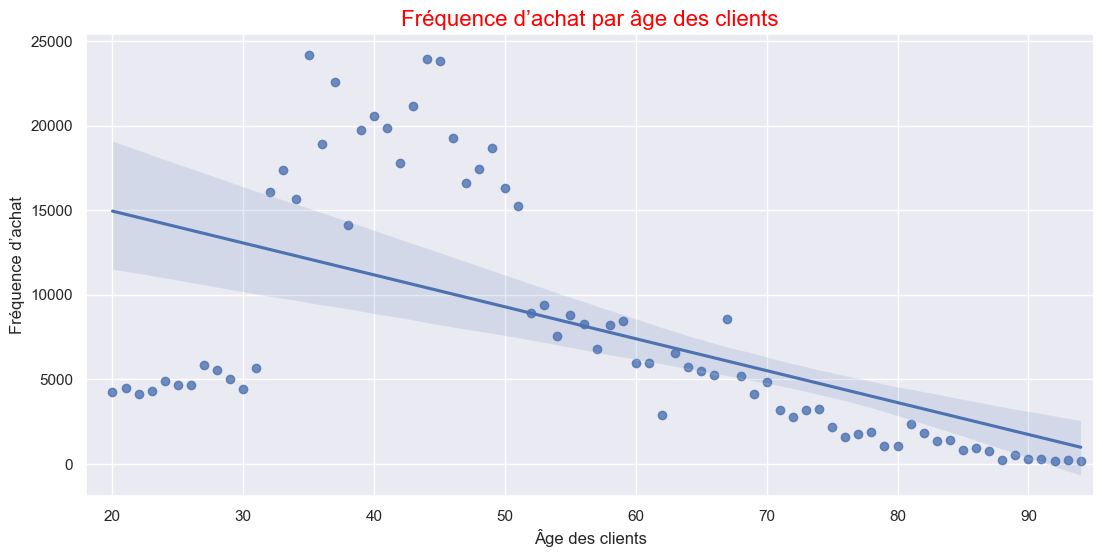

In [166]:
plt.figure(figsize=(13, 6))
sns.regplot(x='age', y='count', data = age_ca)
plt.ylabel( 'Fréquence d’achat')
plt.xlabel('Âge des clients')
plt.title("Fréquence d’achat par âge des clients",fontsize= 16, color = 'red')
plt.xlim(18,95)

In [167]:
print('La covariance est de:', np.cov(age_ca['age'], age_ca['count'],ddof=0)[1,0])
print('Le coefficient de corrélation linéaire est de:', stats.pearsonr(age_ca['age'], age_ca['count'])[0])

La covariance est de: -88449.94666666666
Le coefficient de corrélation linéaire est de: -0.5689694066780078


**Pour tester deux variables quantitatives, avec le test de Pearson, j’obtient un coefficient de -0.57. Il représente une corrélation légèrement négative de nos 2 variables (visible aussi par régression linéaire). Quand on regarde le graphique, on peut voir que cette corrélation concerne plutôt les clients à partir de 52 ans.**

### 3.4 Les corrélations entre l’âge des clients et la taille du panier moyen

In [168]:
age_ca['panier_moyen'] = age_ca['sum']/age_ca['count']
age_ca.head()

,age,count,sum,panier_moyen
0,44.0,23924,323400.70,13.517836
1,35.0,24168,321409.83,13.298983
2,45.0,23834,315423.63,13.234188
3,37.0,22567,299112.68,13.254428
4,43.0,21146,280776.59,13.278000


Text(0.5, 1.0, 'Taille du panier moyen par âge des clients')

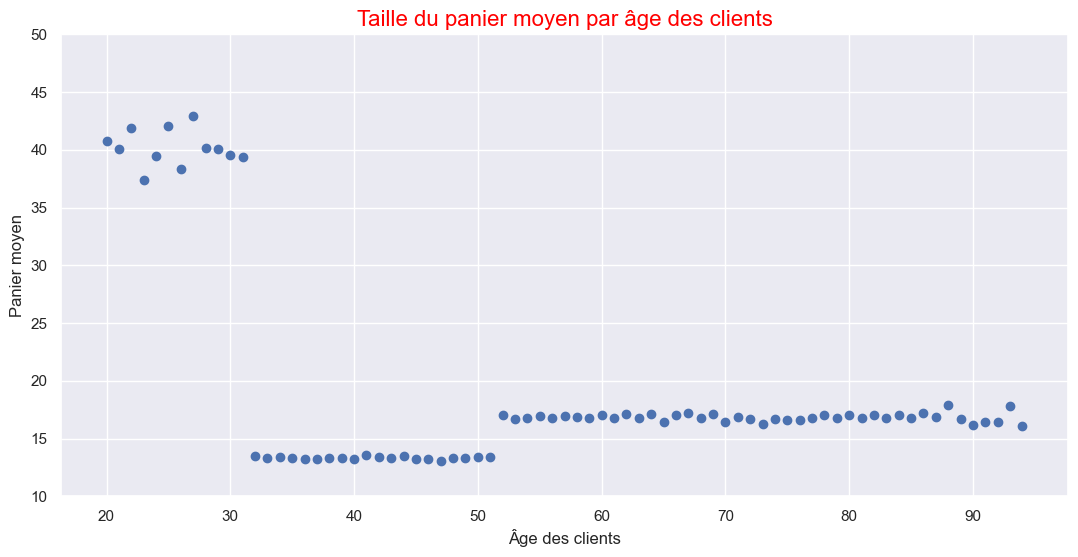

In [169]:
plt.figure(figsize=(13, 6))
plt.ylim(10,50)
plt.scatter(x='age', y='panier_moyen', data = age_ca)
plt.ylabel( 'Panier moyen')
plt.xlabel('Âge des clients')
plt.title("Taille du panier moyen par âge des clients",fontsize= 16, color = 'red')

In [170]:
print('La covariance est de:', np.cov(age_ca['age'], age_ca['panier_moyen'],ddof=0)[1,0])
print('Le coefficient de corrélation linéaire est de:', stats.pearsonr(age_ca['age'], age_ca['panier_moyen'])[0])

La covariance est de: -103.27528821792103
Le coefficient de corrélation linéaire est de: -0.5237271902723906


Conclusion: Avec le test de Pearson, j’obtiens un coefficient de -0.52. Celà représente une corrélation légèrement négative des 2 variables. On observe sur le graphique que:

Les jeunes de moins de 31 ans ont un panier moyen plus élevé avec un montant assez constant (autour de 40 euros) .

Les clients entre 31-50 ans ont une taille du panier moyen le plus basse avec un montant quasi constant (autour de 13 euros) , même si leur fréquence d’achat est la plus élevée.

Les clients à partir de 50 ans ont une taille de panier moyen à montant quasi constant, mais un peu plus élevé (autour de 17 euros).

### 3.5 Les corrélations entre l’âge des clients et les catégories des livres achetés

**Test d'une variable quantitative (âge) et une variable qualitative (catégories), je vais donc effectuer :**

**Une visualisation via boxplot**

**Vérification de la possibilité d'utiliser ANOVA**

**Si c'est le cas, Test ANOVA**

#### 3.5.1 Le Boxplot

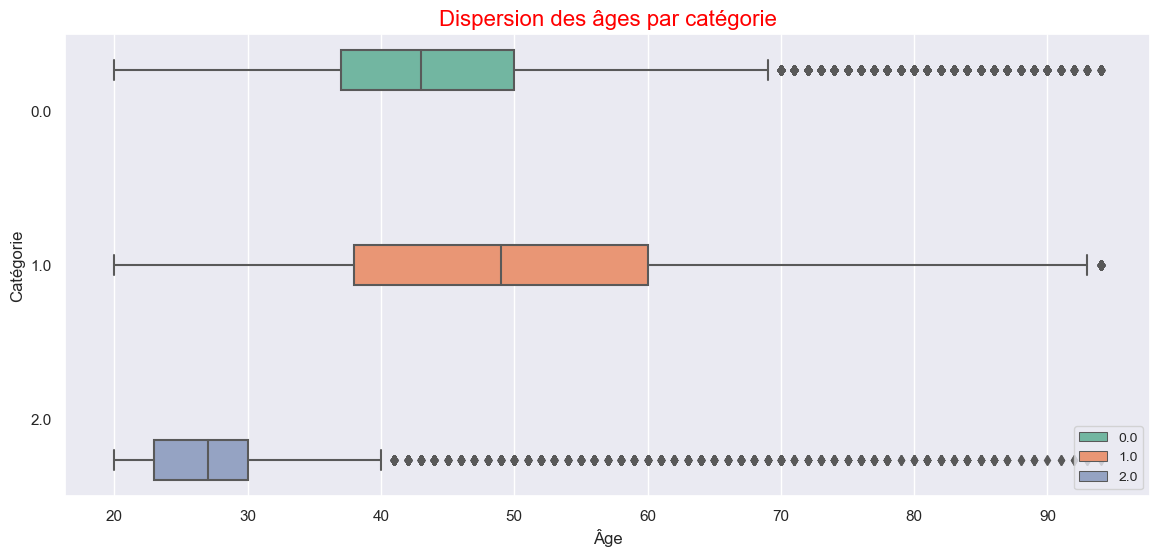

In [171]:
# Dispersion des âges des clients par catégorie
categories = ['catégorie 0', 'catégorie 1', 'catégorie 2']
plt.figure(figsize=(14, 6))
sns.boxplot(y="categ", x="age", data = df, orient='h', hue='categ', palette='Set2')
plt.title('Dispersion des âges par catégorie',fontsize= 16, color = 'red')
plt.xlabel('Âge')
plt.ylabel('Catégorie')
plt.legend(loc='lower right', fontsize=10)

#### 3.5.2 Vérification de la possibilité d'utiliser la méthode ANOVA

Nous devons vérifier que la variable âge suit la loi normale

Avec un risque premier alpha de 5%, on émet les deux hypothèses suivantes:

H0:la variable suit une loi normale

H1:la variable ne suit pas une loi normale

In [172]:
ca_0 = df[df['categ'] == 0]['age']
ca_1= df[df['categ'] == 1]['age']
ca_2 = df[df['categ'] == 2]['age']

In [173]:
# Test la normalité pour les données de catégorie 0
test_stat_0 =kstest(ca_0, 'norm')
test_stat_0

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=20.0, statistic_sign=-1)

In [174]:
# Test la normalité pour les données de catégorie 1
test_stat_1 =kstest(ca_1, 'norm')
test_stat_1

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=20.0, statistic_sign=-1)

In [175]:
# Test la normalité pour les données de catégorie 2
test_stat_2 =kstest(ca_2, 'norm')
test_stat_2

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=20.0, statistic_sign=-1)

**La p-value est pour les 3 catégories égale à 0 : On rejette H0 et donc la catégorie âge ne suit pas la loi normale**

**Conclusion : Comme le test n'est pas possible, nous allons donc utiliser le test de kruskal wallis puis nous verrons par la suite une alternative.**

In [176]:
# Test de Kruskal-Wallis  
result = stats.kruskal(ca_0, ca_1, ca_2)

# Print the result
print(result)

KruskalResult(statistic=61439.92467974249, pvalue=0.0)


**Conclusion : La p value est égale à 0, ce qui signifie qu'il est très peu probable d'obtenir une telle différence entre les groupes si les moyennes étaient en fait identiques. Par conséquent, nous pouvons conclure que les moyennes des groupes sont significativement différentes les unes des autres. Nous alors donc transformer l'âge en une variable catégorie âge, pour pouvoir faire le test entre deux variables qualitatives.**

#### 6.5.3 Modification pour avoir deux variables qualitatives

In [177]:
#Création de trois catégories d'âge dans les deux df principaux

categ_age = []

for row in df.age:
    if row > 50:
        categ_age.append(">50")
    elif row > 30:
        categ_age.append("30-50")
    elif row >= 18:
        categ_age.append("18-29")
    else:
        categ_age.append(np.NaN)

df['categ_age'] = categ_age

categ_age_commandes = []

for row in df_commandes.age:
    if row > 50:
        categ_age_commandes.append(">50")
    elif row > 30:
        categ_age_commandes.append("30-50")
    elif row >= 18:
        categ_age_commandes.append("18-29")
    else:
        categ_age_commandes.append(np.NaN)

df_commandes['categ_age'] = categ_age_commandes

In [178]:
df

,id_prod,date,session_id,client_id,sex,birth,age,price,categ,hour,année,mois,jour,categ_age
0,0_1518,2022-05-20,s_211425,c_103,f,1986.0,37.0,4.18,0.0,13:21:29.043970,2022.0,5.0,20.0,30-50
1,0_1627,2022-06-18,s_225494,c_103,f,1986.0,37.0,3.99,0.0,05:55:31.816994,2022.0,6.0,18.0,30-50
2,0_1104,2023-02-08,s_338755,c_103,f,1986.0,37.0,13.21,0.0,17:31:06.898425,2023.0,2.0,8.0,30-50
3,0_1390,2021-04-20,s_23078,c_103,f,1986.0,37.0,19.37,0.0,06:18:39.939761,2021.0,4.0,20.0,30-50
4,0_1547,2022-03-15,s_179629,c_103,f,1986.0,37.0,8.99,0.0,19:54:53.904123,2022.0,3.0,15.0,30-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679106,0_1509,2021-05-15,s_34762,c_8114,m,1962.0,61.0,4.99,0.0,08:17:35.835342,2021.0,5.0,15.0,>50
679107,1_152,2021-11-08,s_116675,c_240,m,1998.0,25.0,11.06,1.0,17:12:27.637349,2021.0,11.0,8.0,18-29
679108,2_207,2021-06-01,s_42418,c_305,f,1996.0,27.0,50.99,2.0,04:31:16.088314,2021.0,6.0,1.0,18-29
679109,1_521,2022-10-18,s_284060,c_305,f,1996.0,27.0,22.99,1.0,00:38:49.629165,2022.0,10.0,18.0,18-29


#### 6.5.4 Analyse de deux données qualitatives

**Tableau de contingence**

In [179]:
x = 'categ_age'
y = 'categ'
cont_age = df[[x, y]].pivot_table(index=x, columns=y,aggfunc=len, margins=True, margins_name='Total' )
cont_age

categ,0.0,1.0,2.0,Total
categ_age,,,,
18-29,11440,19998,20830,52268
30-50,275560,90519,3634,369713
>50,79581,94589,1501,175671
Total,366581,205106,25965,597652


**Test de Khi2**

Avec un risque premier alpha de 5%, on émet les deux hypothèses suivantes:

H0: Les deux variables (les tranches d'age des clients et les catégories des livres achetés ) sont indépendantes
                        
H1: les deux variables ne sont pas indépendantes

In [180]:
chi2, pvalue, degrees, expected = stats.chi2_contingency(cont_age)
chi2, degrees, pvalue

(227523.33793006546, 9, 0.0)

**p-value = 0 < 0,05 : On rejette H0 et on conclut que les deux variables ne sont pas indépendantes**

**Heatmap**

In [181]:
# Réalisation d'une heatmap

# Tableau de contingence réel
df.categ_age = df.categ_age.astype("str")

X = "categ"
Y ="categ_age"
d = df[[X,Y]].pivot_table(index=X, columns=Y, aggfunc=len)
d.head(3)

categ_age,18-29,30-50,>50
categ,,,
0.0,11440,275560,79581
1.0,19998,90519,94589
2.0,20830,3634,1501


In [182]:
cont=d.copy()
tx=df[X].value_counts()
ty=df[Y].value_counts()

cont.loc[:,"Total"]=tx
cont.loc["total",:]=ty
cont.loc["total","Total"]=len(df)

cont

categ_age,18-29,30-50,>50,Total
categ,,,,
0.0,11440.0,275560.0,79581.0,366581.0
1.0,19998.0,90519.0,94589.0,205106.0
2.0,20830.0,3634.0,1501.0,25965.0
total,52268.0,369713.0,175671.0,612421.0


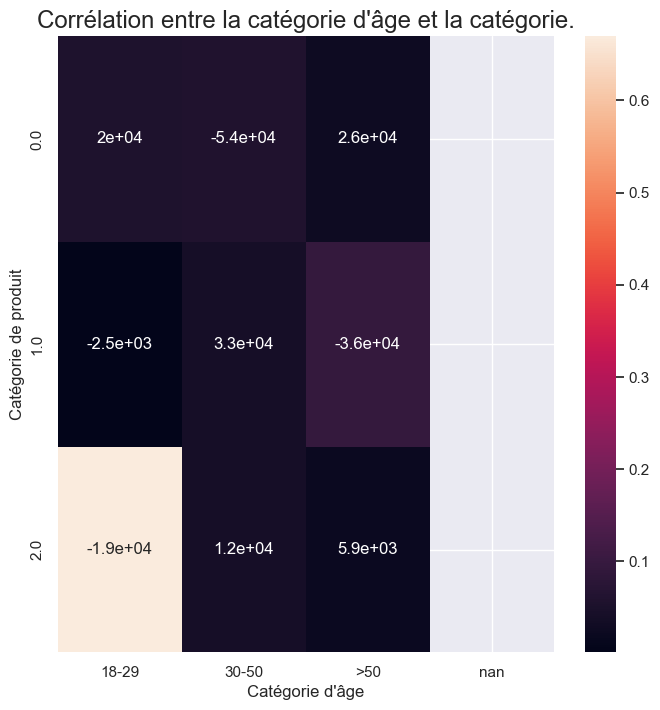

In [183]:
# Tableau de contingence théorique

tx = pd.DataFrame(tx)
ty = pd.DataFrame(ty)
tx.columns= ['foo']
ty.columns= ['foo']
n = len(df)
indep = tx.dot(ty.T)/n

indep.sort_index(axis=1, inplace=True)
indep.sort_index(inplace=True)

mesure = (d-indep)**2/indep
xi_n = mesure.sum().sum()

plt.figure(figsize=(8,8))
sns.heatmap(mesure/xi_n, annot=indep - d)
plt.title("Corrélation entre la catégorie d'âge et la catégorie.", fontsize = 'x-large')
plt.xlabel("Catégorie d'âge")
plt.ylabel("Catégorie de produit")
plt.show()

**Conclusion:**

**Avec le heatmap, on trouve qu'il y a une forte corrélation entre les personnes âgés de moins de 29 ans et la catégorie 2 de produits: la catégorie 2 est la préférée des jeunes.**

**Il serait donc opportun de cibler cette catégorie d'âge lors des campagne de publicité concernant les produits de la catégorie 2.**

### 3.6 Les probabilités

In [89]:
df.head()

,id_prod,date,session_id,client_id,sex,birth,age,price,categ,hour,année,mois,jour,categ_age
0,0_1518,2022-05-20,s_211425,c_103,f,1986.0,37.0,4.18,0.0,13:21:29.043970,2022.0,5.0,20.0,30-50
1,0_1627,2022-06-18,s_225494,c_103,f,1986.0,37.0,3.99,0.0,05:55:31.816994,2022.0,6.0,18.0,30-50
2,0_1104,2023-02-08,s_338755,c_103,f,1986.0,37.0,13.21,0.0,17:31:06.898425,2023.0,2.0,8.0,30-50
3,0_1390,2021-04-20,s_23078,c_103,f,1986.0,37.0,19.37,0.0,06:18:39.939761,2021.0,4.0,20.0,30-50
4,0_1547,2022-03-15,s_179629,c_103,f,1986.0,37.0,8.99,0.0,19:54:53.904123,2022.0,3.0,15.0,30-50


In [90]:
#On affiche le produit 0_1518
df.loc[df['id_prod'] == '0_1518']

,id_prod,date,session_id,client_id,sex,birth,age,price,categ,hour,année,mois,jour,categ_age
0,0_1518,2022-05-20,s_211425,c_103,f,1986.0,37.0,4.18,0.0,13:21:29.043970,2022.0,5.0,20.0,30-50
30,0_1518,2021-07-20,s_64849,c_103,f,1986.0,37.0,4.18,0.0,13:21:29.043970,2021.0,7.0,20.0,30-50
46,0_1518,2022-08-20,s_255965,c_103,f,1986.0,37.0,4.18,0.0,13:21:29.043970,2022.0,8.0,20.0,30-50
10372,0_1518,2022-05-27,s_214775,c_7456,f,1985.0,38.0,4.18,0.0,12:41:28.779302,2022.0,5.0,27.0,30-50
10401,0_1518,2021-11-27,s_125853,c_7456,f,1985.0,38.0,4.18,0.0,12:41:28.779302,2021.0,11.0,27.0,30-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658600,0_1518,2021-11-02,s_113783,c_8457,m,1985.0,38.0,4.18,0.0,16:59:38.401972,2021.0,11.0,2.0,30-50
662070,0_1518,2022-10-05,s_277972,c_66,f,1968.0,55.0,4.18,0.0,04:56:32.287298,2022.0,10.0,5.0,>50
662074,0_1518,2021-08-05,s_71554,c_66,f,1968.0,55.0,4.18,0.0,04:56:32.287298,2021.0,8.0,5.0,>50
672922,0_1518,2022-02-09,s_162204,c_1484,f,1960.0,63.0,4.18,0.0,01:27:10.984336,2022.0,2.0,9.0,>50


In [91]:
#On affiche le produit 0_1104
df.loc[df['id_prod'] == '0_1104']

,id_prod,date,session_id,client_id,sex,birth,age,price,categ,hour,année,mois,jour,categ_age
2,0_1104,2023-02-08,s_338755,c_103,f,1986.0,37.0,13.21,0.0,17:31:06.898425,2023.0,2.0,8.0,30-50
85,0_1104,2021-08-08,s_73072,c_103,f,1986.0,37.0,13.21,0.0,17:31:06.898425,2021.0,8.0,8.0,30-50
181,0_1104,2022-07-08,s_235516,c_103,f,1986.0,37.0,13.21,0.0,17:31:06.898425,2022.0,7.0,8.0,30-50
10343,0_1104,2021-12-09,s_131934,c_7456,f,1985.0,38.0,13.21,0.0,20:02:31.194716,2021.0,12.0,9.0,30-50
10361,0_1104,2022-12-09,s_309619,c_7456,f,1985.0,38.0,13.21,0.0,20:02:31.194716,2022.0,12.0,9.0,30-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672918,0_1104,2021-12-15,s_134973,c_1484,f,1960.0,63.0,13.21,0.0,23:37:12.364379,2021.0,12.0,15.0,>50
672931,0_1104,2022-06-15,s_224449,c_1484,f,1960.0,63.0,13.21,0.0,23:37:12.364379,2022.0,6.0,15.0,>50
677001,0_1104,2022-07-08,s_235585,c_8040,f,1987.0,36.0,13.21,0.0,22:00:31.760560,2022.0,7.0,8.0,30-50
677006,0_1104,2021-08-08,s_73141,c_8040,f,1987.0,36.0,13.21,0.0,22:00:31.760560,2021.0,8.0,8.0,30-50


In [92]:
df_0_1518 = df[df['id_prod'] == '0_1518'] #On selectionne toutes les références 0_1518
df_0_1104 = df[df['id_prod'] == '0_1104'] #On selectionne toutes les références 0_1104
df_0_1518 =df_0_1518['client_id'].drop_duplicates() #On selectionne les clients unique de la référence 0_1518
df_0_1104 =df_0_1104['client_id'].drop_duplicates() #On selectionne les clients unique de la référence 0_1104
nb_client_commun = len(df_0_1104.isin(df_0_1518)) #On selectionne les clients unique qui ont commandés les deux références
proba=(nb_client_commun/len(df_0_1518))*100  #On calcul la probabilité
#On affiche la probabilité
print("La Probabilité qu'un client achète la référence 0_1104 sachant qu'il a acheté la référence 0_1518 est de:",proba,"%" )

La Probabilité qu'un client achète la référence 0_1104 sachant qu'il a acheté la référence 0_1518 est de: 86.64259927797833 %
